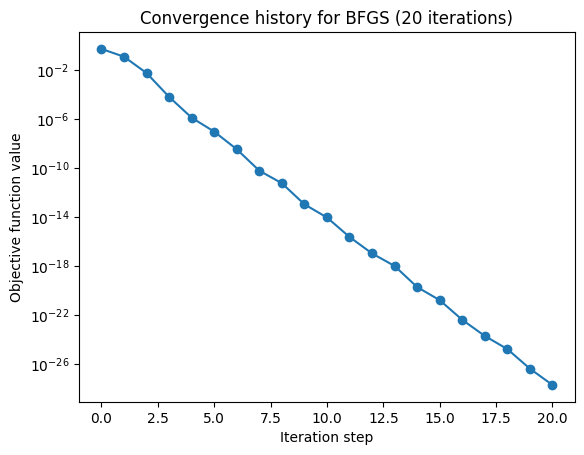

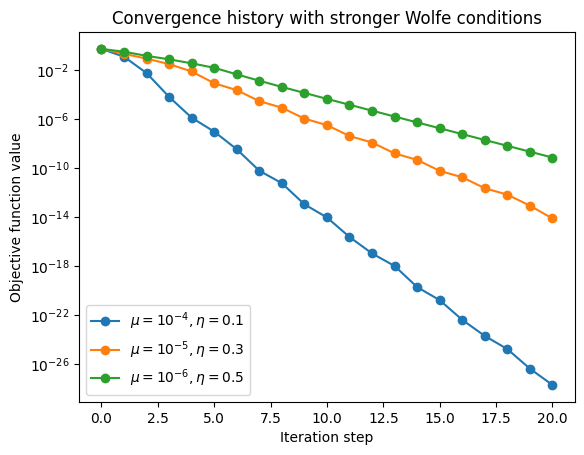

C:\Users\peter\AppData\Local\Temp\ipykernel_19624\2490240084.py:20: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z_))


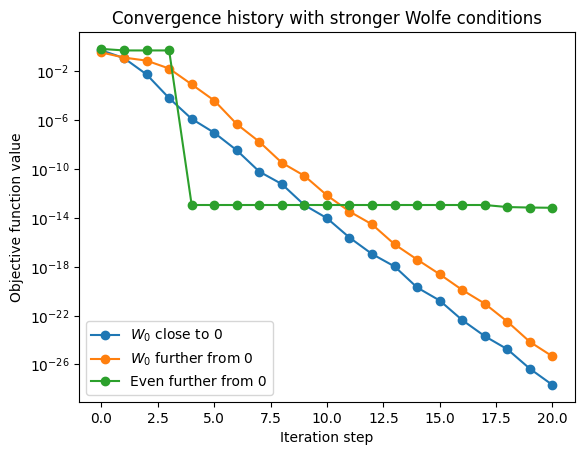

In [3]:
import numpy as np
import matplotlib.pyplot as plt

y = np.array([[1.2, 2.4, 1.7], [-1.3, 1.0, 0.0], [0.0, 1.3, 0.4], [0.2, 0.5, 0.9], [-0.3, 1.1, -0.6], [-1.2, -0.7, -0.1]])
z = np.array([[1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1]])
x_0 = np.random.randn(6)*0.01
x_1 = np.random.randn(6)
x_2 = np.random.randn(6)*100
W_0 = x_0.reshape(3,2)
W_1 = x_1.reshape(3,2)
W_2 = x_2.reshape(3,2)
n = len(y[0])
m = len(y)

def z_bar(y, W=W_0):
    return y@W

def z_hat(y, W=W_0):
    z_ = z_bar(y,W)
    return 1 / (1 + np.exp(-z_))

# objective function computing the mean squared error
def obj_f(y,z, W=W_0):
    z_ = z_hat(y,W)  # Predicted values
    return np.mean(np.sum((z-z_)**2, axis=1))

# function computing the gradient
def grad_f(y, z, W=W_0):
    z_ = z_hat(y, W)  # computed z values 
    diff = z - z_     # difference between computed and given z values
    grad = -(y.T @ (diff*z_*(1-z_)))/m
    return grad

# function for the line search using the Wolfe conditions
def line_search(y,z,W,p, alpha_0=1, mu=1e-4, eta=0.1):
    alpha = alpha_0
    f_current = obj_f(y,z,W)
    grad_current = grad_f(y,z,W)
    grad_dot_p = np.sum(grad_current*p)

    if grad_dot_p >= 0:
        print("p is not a descend.")
        return

    while True:
        W_new = W + alpha*p
        f_new = obj_f(y,z,W_new)
        grad_new = grad_f(y,z,W_new)

        armijo = f_new <= f_current + mu*alpha*grad_dot_p
        curvature = np.sum(grad_new*p) >= eta*grad_dot_p
        
        # if conditions are fulfilled, break out of the loop and return alpha
        if armijo and curvature:
            break
        
        # set up the conditions as specified in the task
        if np.sum(grad_new*p)*grad_dot_p < 0:
            alpha = alpha/1.5
        else:
            alpha = alpha*2
    
    return alpha

def bfgs(y, z, W_0, max_iter=20, alpha_0=1, mu=1e-4, eta=0.1):
    W = W_0.copy()
    B_inv = np.eye(W.size)
    hist = []
    hist.append(obj_f(y,z,W))
    grad = grad_f(y,z,W).flatten()

    for _ in range(max_iter):
        p = -B_inv @ grad
        p = p.reshape(W.shape)

        # line search
        alpha = line_search(y,z,W,p,alpha_0,mu,eta)

        # the new weights
        W_new = W + alpha*p
        grad_new = grad_f(y,z,W_new).flatten()

        # differences between old and new weights
        s = (W_new - W).flatten()
        y_k = grad_new - grad

        # new inv. hessian approx.
        rho = 1/np.dot(y_k,s)
        E = np.eye(len(s))
        B_inv = (E-rho*np.outer(s,y_k)) @ B_inv @ (E-rho*np.outer(y_k,s)) + rho*np.outer(s,s)

        # new weight and gradient
        W = W_new
        grad = grad_new

        # save obj. function value in hist list
        hist.append(obj_f(y,z,W))

    return hist

# convergence history for 20 iterations
conv_hist = bfgs(y,z,W_0,20)

plt.plot(range(len(conv_hist)), conv_hist, 'o-', label=r'$\mu=10^{-4}, \eta=0.1$')
plt.xlabel("Iteration step")
plt.ylabel("Objective function value")
plt.yscale('log')
plt.title("Convergence history for BFGS (20 iterations)")
plt.show()

conv_hist_2 = bfgs(y,z,W_0,20,1,mu=1e-5,eta=0.3)
conv_hist_3 = bfgs(y,z,W_0,20,1,mu=1e-6,eta=0.5)

plt.plot(range(len(conv_hist)), conv_hist, 'o-', label=r'$\mu=10^{-4}, \eta=0.1$')
plt.plot(range(len(conv_hist_2)), conv_hist_2, 'o-', label=r'$\mu=10^{-5}, \eta=0.3$')
plt.plot(range(len(conv_hist_3)), conv_hist_3, 'o-', label=r'$\mu=10^{-6}, \eta=0.5$')
plt.xlabel("Iteration step")
plt.ylabel("Objective function value")
plt.yscale('log')
plt.legend(loc='lower left')
plt.title("Convergence history with stronger Wolfe conditions")
plt.show()

conv_hist_4 = bfgs(y,z,W_1,20,1,mu=1e-4,eta=0.1)
conv_hist_5 = bfgs(y,z,W_2,20,1,mu=1e-4,eta=0.1)

plt.plot(range(len(conv_hist)), conv_hist, 'o-', label=r"$W_0$ close to 0")
plt.plot(range(len(conv_hist_4)), conv_hist_4, 'o-', label=r"$W_0$ further from 0")
plt.plot(range(len(conv_hist_5)), conv_hist_5, 'o-', label=r"Even further from 0")
plt.xlabel("Iteration step")
plt.ylabel("Objective function value")
plt.yscale('log')
plt.legend(loc='lower left')
plt.title("Convergence history with stronger Wolfe conditions")
plt.show()
